# Evaluation of trained network for temporal super-resolution

In [1]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import display
from utils.evaluate_utils import *
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

In [2]:
df = pd.read_csv('../results/Overview_models.csv')
df1 = df[['Name', 'notes']]
display(df1)

,Name,notes
0,Temporal4DFlowNet_20230210-0333,NaN
1,Temporal4DFlowNet_20230215-1029,NaN
2,Temporal4DFlowNet_20230217-0602,NaN
3,Temporal4DFlowNet_20230220-0908,NaN
4,Temporal4DFlowNet_20230301-1127,First training on radial sampled data
5,Temporal4DFlowNet_20230301-1641,Basecheck with adapted network code and higher...
6,Temporal4DFlowNet_20230301-1654,First training with densenet blocks (Densenet)
7,Temporal4DFlowNet_20230301-1704,First training with cspnet blocks (CSPnet)
8,Temporal4DFlowNet_20230305-1001,Less depth: 4 -2
9,Temporal4DFlowNet_20230305-1002,Depth change (balance between high lowres bloc...


### Set model and dataset to evaluate


In [3]:
# Define directories and filenames

model_name = '20230301-1641'#'20230313-0948'#'20230301-1641'  #'20230308-1226'# #'#'20230308-1226' #'20230301-1641'  '20230301-1654', '20230301-1704'
set_name = 'Test'               
data_model= '4'
step = 2

use_dynamical_mask = False

### Set evaluation files to compare relative error to


In [4]:
vel_colnames=['u', 'v', 'w']
vel_colnames_fluid = ['u_fluid', 'v_fluid', 'w_fluid']

def load_data(model_name, set_name, data_model, step,dynamic_mask_used, ending_file= ''):
    #directories
    gt_dir = '../data/CARDIAC'
    result_dir = f'../results/Temporal4DFlowNet_{model_name}'
    eval_dir = f'{result_dir}/plots'
    lr_dir = '../data/CARDIAC'

    inbetween_string = ''
    if dynamic_mask_used:
        inbetween_string = '_dynamic'

    #filenames
    gt_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}.h5'
    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'
    result_filename = f'{set_name}set_result_model{data_model}_2mm_step{step}_{model_name[-4::]}_temporal{ending_file}.h5' #_newpadding
    evaluation_filename = f'eval_rel_err_{data_model}_2mm_step{step}_{model_name[-4::]}_temporal.h5'

    print(gt_filename, lr_filename)

    if not os.path.isdir(eval_dir):
        os.makedirs(eval_dir)

    #Params for evalation
    save_relative_error_file= False

    # Setting up
    gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
    res_filepath = '{}/{}'.format(result_dir, result_filename)
    lr_filepath = '{}/{}'.format(lr_dir, lr_filename)
    

    if save_relative_error_file:
        assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

    
    gt = {}
    lr = {}
    pred = {}

    with h5py.File(res_filepath, mode = 'r' ) as h_pred:
        with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
            with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
                
                gt["mask"] = np.asarray(h_gt["mask"]).squeeze()
                gt["mask"][np.where(gt["mask"] !=0)] = 1
                if len(gt['mask'].shape) == 4 : # check for dynamical mask, otherwise create one
                    temporal_mask = gt['mask'].copy()
                else:
                    print('Create static temporal mask for model')
                    temporal_mask = create_temporal_mask(gt["mask"], h_gt['u'].shape[0])
                gt['mask'] = temporal_mask.copy()
                # adapt dimension
                for vel in vel_colnames:
                    
                    gt[vel] = np.asarray(h_gt[vel])
                    pred[vel] = np.asarray(h_pred[f'{vel}_combined'])   
                    lr[vel] = np.asarray(h_lr[vel])[::2, :, :, :]       

                    # add information considering only the fluid regions  
                    pred[f'{vel}_fluid'] =np.multiply(pred[vel], temporal_mask)
                    lr[f'{vel}_fluid'] =  np.multiply(lr[vel], temporal_mask[::2, :, :, :])
                    gt[f'{vel}_fluid'] =  np.multiply(gt[vel], temporal_mask)

                    
                #include speed calculations
                gt['speed']   = np.sqrt(gt["u"]**2 + gt["v"]**2 + gt["w"]**2)
                lr['speed']   = np.sqrt(lr["u"]**2 + lr["v"]**2 + lr["w"]**2)
                pred['speed'] = np.sqrt(pred["u"]**2 + pred["v"]**2 + pred["w"]**2)


    return lr, gt, pred, temporal_mask, eval_dir

def load_interpolation(data_model, step, lr, gt, use_dynamical_mask):
    
    interpolate_NN = {}
    interpolate_linear = {}
    interpolate_cubic = {}

    inbetween_string = ''
    if use_dynamical_mask:
        inbetween_string = '_dynamic'

    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'


    interpolation_file= f'../results/interpolation/{lr_filename[:-3]}_interpolation'
    if not os.path.isfile(interpolation_file):
        print("Interpolation file does not exist - calculate interpolation and save files")
        print("Save interpolation files to: ", interpolation_file)
        
        #this can take a while
        for vel in vel_colnames:
            print("Interpolate low resolution images - ", vel)
            print(gt['mask'].shape)
            interpolate_linear[vel] = temporal_linear_interpolation(lr[vel], gt[vel].shape)
            interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])

            interpolate_cubic[vel] = temporal_cubic_interpolation(lr[vel], gt[vel].shape)
            interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])

            interpolate_NN[vel] = temporal_NN_interpolation(lr[vel], gt[vel].shape)
            interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

            prediction_utils.save_to_h5(interpolation_file, f'linear_{vel}' , interpolate_linear[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'cubic_{vel}' , interpolate_cubic[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'NN_{vel}' , interpolate_NN[vel], compression='gzip')
    else:
        print("Load existing interpolation file")
        with h5py.File(interpolation_file, mode = 'r' ) as h_interpolate:
            for vel in vel_colnames:
                interpolate_linear[vel] = np.array(h_interpolate[f'linear_{vel}'])
                interpolate_cubic[vel] =  np.array(h_interpolate[f'cubic_{vel}'])
                interpolate_NN[vel] =     np.array(h_interpolate[f'NN_{vel}'])


                interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])
                interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])
                interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

    return interpolate_linear, interpolate_cubic, interpolate_NN

lr, gt, pred, temporal_mask, eval_dir = load_data(model_name, set_name, data_model, step, use_dynamical_mask)
interpolate_linear, interpolate_cubic, interpolate_NN = load_interpolation(data_model, step,lr, gt, use_dynamical_mask)

M4_2mm_step2_static.h5 M4_2mm_step2_static_noise.h5
Create static temporal mask for model
Create static temporal mask.
Load existing interpolation file


### Calculate relative error and mean speed

In [5]:
rel_error =calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
error_pointwise, error_absolut = calculate_pointwise_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

for vel in vel_colnames:
    error_absolut[f'{vel}_fluid'] = np.multiply(error_absolut[vel], gt["mask"])

# mean speed of gt and prediction
gt['mean_speed'] = calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])
pred['mean_speed'] = calculate_mean_speed(pred["u_fluid"], pred["v_fluid"] , pred["w_fluid"], gt["mask"])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], gt["mask"])
interpolate_cubic['mean_speed'] = calculate_mean_speed(interpolate_cubic["u_fluid"], interpolate_cubic["v_fluid"] , interpolate_cubic["w_fluid"], gt["mask"])

max/min before tanh 52297.324 0.0
max/min after tanh 1.0 0.0


2023-03-15 09:45:37.459811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:45:37.460137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:45:37.487502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:45:37.487849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:45:37.488135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

max/min before tanh 346410.16 0.0
max/min after tanh 1.0 0.0
max/min before tanh 1348533.0 0.0
max/min after tanh 1.0 0.0


In [6]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

#get boundary points
bounds, core_mask = get_boundaries(temporal_mask)


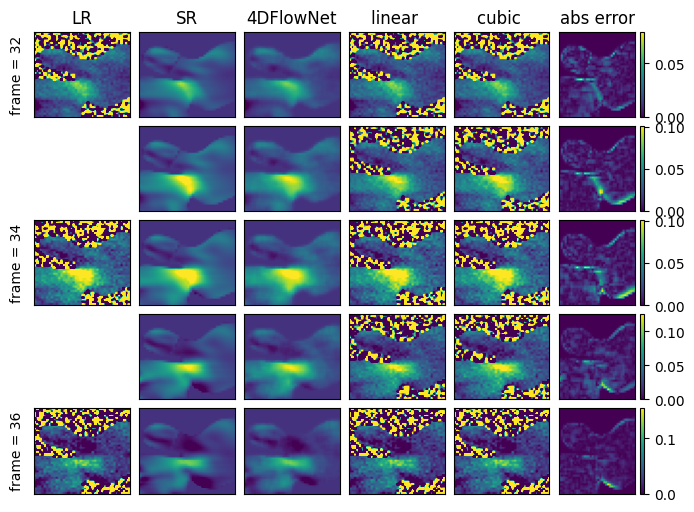

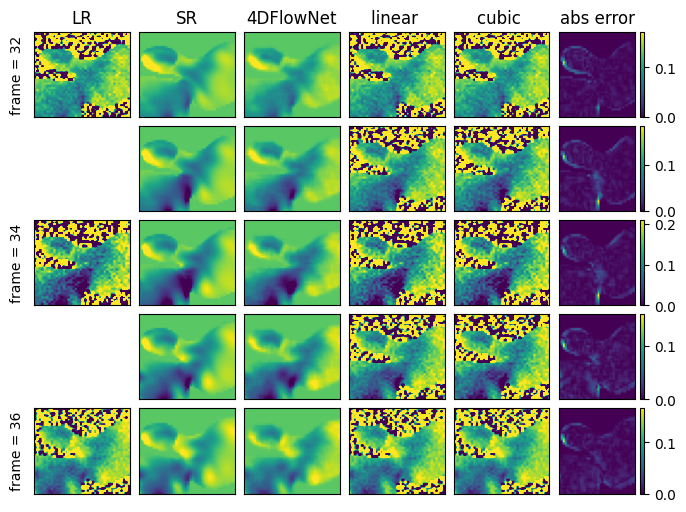

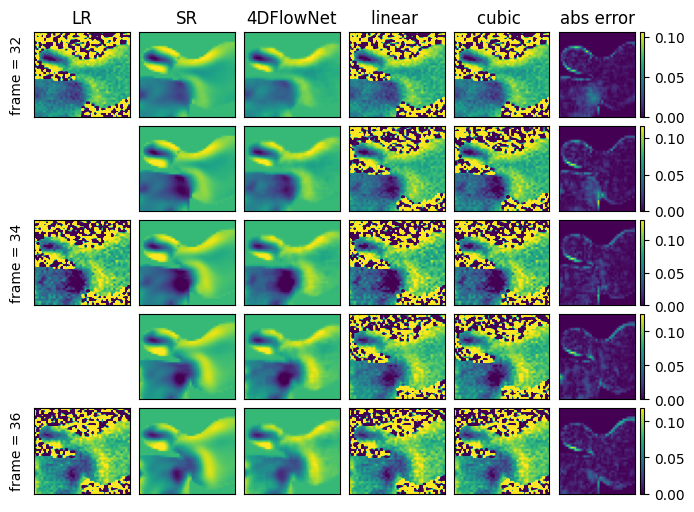

In [7]:

def show_timeframes_jupyter(gt_cube,lr_cube,  pred_cube,mask_cube, rel_error_cube, comparison_lst, comparison_name, timepoints, axis, idx,min_v, max_v,save_as = "Frame_comparison.png"):
    fig = plt.figure(figsize=(8,6))
    T = len(timepoints)
    N = 4 + len(comparison_lst)
    i = 1
    idxs = get_indices(timepoints, axis, idx)
    gt_cube = gt_cube[idxs]
    mask_cube = mask_cube[idxs]
    pred_cube = pred_cube[idxs]
    #lr = lr[idxs]

    min_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.01)
    max_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.99)
    for j,t in enumerate(timepoints):
        
        gt_slice = gt_cube[j]#get_slice(gt, t,  axis=axis, slice_idx=idx )
        pred_slice = pred_cube[j]#get_slice(pred, t, axis=axis, slice_idx=idx )

        lr_slice = np.zeros_like(gt_slice)
        if t%2 == 0: lr_slice = get_slice(lr_cube, t//2, axis=axis, slice_idx=idx )

        plt.subplot(T, N, i)

        if t%2 == 0:
            plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i == 1: plt.title("LR")
            plt.xticks([])
            plt.yticks([])
            plt.ylabel('frame = '+ str(t))
            
        else:
            #plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='jet', aspect='auto')
            plt.ylabel('frame = '+ str(t))
            plt.axis('off')
        

        i +=1
        plt.subplot(T, N, i)
        plt.imshow(gt_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
        if i == 2: plt.title("SR")
        plt.xticks([])
        plt.yticks([])

        i +=1
        plt.subplot(T, N, i)
        plt.imshow(pred_slice, vmin = min_v, vmax = max_v, cmap='viridis',aspect='auto')
        if i == 3: plt.title("4DFlowNet")
        plt.xticks([])
        plt.yticks([])


        for comp, name in zip(comparison_lst, comparison_name):
            i +=1
            plt.subplot(T, N, i)
            plt.imshow(get_slice(comp,t, axis=axis, slice_idx=idx), vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i-1 == (i-1)%N: plt.title(name)
            plt.xticks([])
            plt.yticks([])

        # plt.colorbar(get_slice(comp,t, axis=axis, slice_idx=idx))

        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        # fig.colorbar(cax=cbar_ax)   

        i +=1
        plt.subplot(T, N, i)
        plt.imshow(get_slice(rel_error_cube, t, axis, idx),cmap='viridis',aspect='auto')
        if i-1 == (i-1)%N: plt.title("abs error")
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()

        
        i +=1

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.savefig(save_as,bbox_inches='tight' )
    # plt.tight_layout()

a = 0
idx_cube = np.index_exp[:, :, 0:40, 20:60]


show_timeframes_jupyter(gt['u'][idx_cube],lr['u'][idx_cube],  pred['u'][idx_cube],temporal_mask[idx_cube], error_absolut['u'][idx_cube], [interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['linear ','cubic '], [32, 33, 34, 35, 36], axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/Frame_comparison_u.png")
show_timeframes_jupyter(gt['v'][idx_cube],lr['v'][idx_cube],  pred['v'][idx_cube],temporal_mask[idx_cube], error_absolut['v'][idx_cube], [interpolate_linear['v'][idx_cube],interpolate_cubic['v'][idx_cube]], ['linear ','cubic '], [32, 33, 34, 35, 36], axis=a, idx=30,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/Frame_comparison_v.png")
show_timeframes_jupyter(gt['w'][idx_cube],lr['w'][idx_cube],  pred['w'][idx_cube],temporal_mask[idx_cube], error_absolut['w'][idx_cube], [interpolate_linear['w'][idx_cube],interpolate_cubic['w'][idx_cube]], ['linear ','cubic '], [32, 33, 34, 35, 36], axis=a, idx=30,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/Frame_comparison_w.png")



#### Compare different axis predicrrion with averaged prediction


In [8]:
# pred_axis0 = {}
# pred_axis1 = {}
# pred_axis2 = {}
# vel_colnames=['u', 'v', 'w']
# #Compare the combined and not combined evaulations
# with h5py.File(res_filepath, mode = 'r' ) as h_pred:
#     for vel in vel_colnames:
#         pred_axis0[vel] = np.asarray(h_pred[f'{vel}_axis0'])   
#         pred_axis1[vel] = np.asarray(h_pred[f'{vel}_axis1'])  
#         pred_axis2[vel] = np.asarray(h_pred[f'{vel}_axis2'])  

#         pred_axis0[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis0[vel])
#         pred_axis1[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis1[vel])
#         pred_axis2[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis2[vel])

# rel_error_axis0 = calculate_relative_error_normalized(pred_axis0["u"], pred_axis0["v"], pred_axis0["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# rel_error_axis1 = calculate_relative_error_normalized(pred_axis1["u"], pred_axis1["v"], pred_axis1["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# rel_error_axis2 = calculate_relative_error_normalized(pred_axis2["u"], pred_axis2["v"], pred_axis2["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# mean_speed_axis0 = calculate_mean_speed(pred_axis0["u_fluid"], pred_axis0["v_fluid"] , pred_axis0["w_fluid"], gt["mask"])
# mean_speed_axis1 = calculate_mean_speed(pred_axis1["u_fluid"], pred_axis1["v_fluid"] , pred_axis1["w_fluid"], gt["mask"])
# mean_speed_axis2 = calculate_mean_speed(pred_axis2["u_fluid"], pred_axis2["v_fluid"] , pred_axis2["w_fluid"], gt["mask"])



# plt.subplot(2, 1, 1)
# #plot_relative_error([gt_filepath],[res_filepath], [set_name])

# #plt.legend(lst_names)
# plt.title("Relative error")
# plt.plot(rel_error, label = 'averaged prediction')
# # plt.plot(rel_error_axis0, label = "axis 0")
# # plt.plot(rel_error_axis1, label = "axis 1")
# # plt.plot(rel_error_axis2, label = "axis 2")
# plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
# plt.plot(50*np.ones(len(rel_error)), 'k:')
# plt.xlabel("Frame")
# plt.ylabel("Relative error (%)")
# plt.ylim((0, 100))
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
# plt.plot(pred['mean_speed'],'b', label= set_name, color = 'steelblue')
# # plt.plot(mean_speed_axis0, label = "axis 0")
# # plt.plot(mean_speed_axis1, label = "axis 1")
# # plt.plot(mean_speed_axis2, label = "axis 2")
# plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolation', color = 'yellowgreen')
# # plt.plot(mean_speed_cubic_interpolation[:-1], label = 'cubic interpoaltion', color = 'forestgreen')
# plt.xlabel("Frame")
# plt.ylabel("Mean speed (cm/s)")
# plt.legend()

# plt.savefig(f'{eval_dir}/Erl_error_{set_name}.svg')
# plt.show()



### Show results including non-fluid region
 

In [9]:


@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 10, vel = "u"):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 5, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("LR")
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(interpolate_linear[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("Linear Interpolation")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(interpolate_cubic[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("Cubic Interpolation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=10, description='x', ma…

### Show results with only fluid region

In [10]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames_fluid, patch_size=(10, 30))
def f(frame=5, x = 10, vel = "u", patch_size=20):
    plt.figure(figsize=(20,10))
    N = 7
    mid_y = gt["u"].shape[2]//2
    mid_z = gt["u"].shape[3]//2
    idxs = np.index_exp[frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]

    plt.subplot(1, N, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]), vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')
    
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(gt[vel][idxs], vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(pred[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow(interpolate_linear[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Linear")
    plt.axis('off')

    plt.subplot(1, N, 5)
    plt.imshow(interpolate_cubic[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Cubic")
    plt.axis('off')

    plt.subplot(1, N, 6)
    plt.imshow(error_pointwise[idxs], cmap='viridis')
    plt.title("Relative error")
    plt.axis('off')

    plt.subplot(1, N, 7)
    plt.imshow(error_absolut[vel][idxs], cmap='viridis')
    plt.title("Absolute error")
    plt.axis('off')

    plt.tight_layout()
    #plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=10, description='x', ma…

#### Plot histogram of velocities

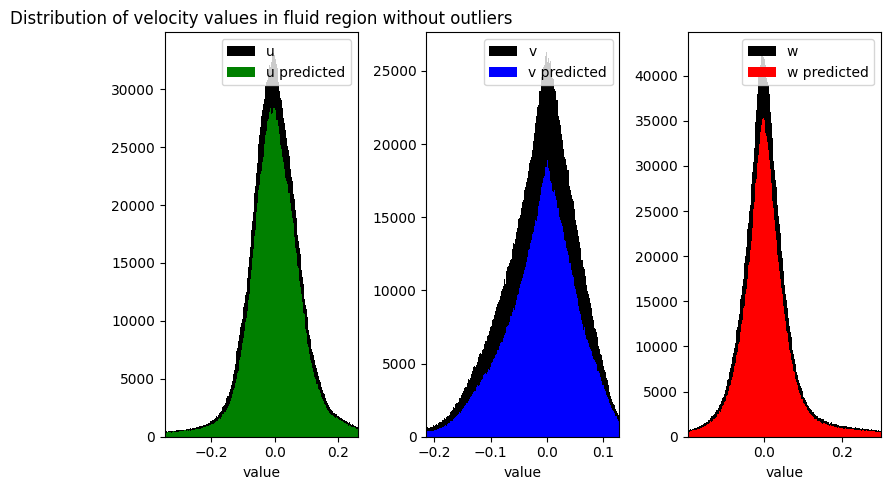

In [11]:
compare_velocitywise = False
plt.figure(figsize=(8, 5))

if compare_velocitywise:

    plt.subplot(2,1, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u')
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v')
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(2,1, 2)
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.show()

else:
    plt.subplot(1, 3, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'u')
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u predicted')    
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = 'v')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v predicted')
    plt.xlim(np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.legend()
    plt.xlabel('value')

    plt.subplot(1, 3, 3)
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = 'w')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w predicted')
    plt.xlim(np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot relative error and mean speed 

Text(0.5, 1.0, 'RMSE')

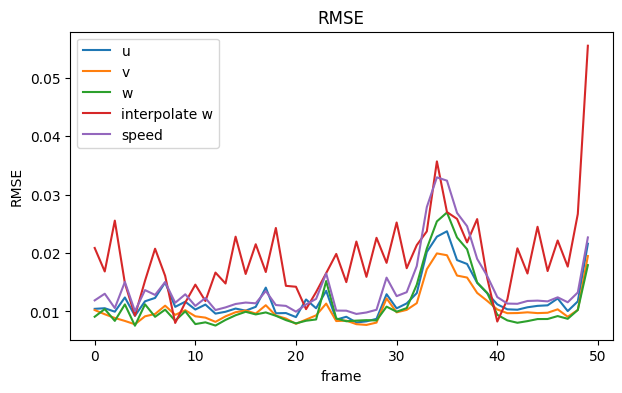

In [12]:
plt.figure(figsize=(7, 4))

plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = 'u')
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = 'v')
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = 'w')
plt.plot(calculate_rmse(interpolate_linear['w'], gt['w'], gt['mask']), label = 'interpolate w')
plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('frame')
plt.title('RMSE')

/tmp/ipykernel_993998/4018646248.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(pred['mean_speed'],'b', label= set_name, color = 'steelblue')


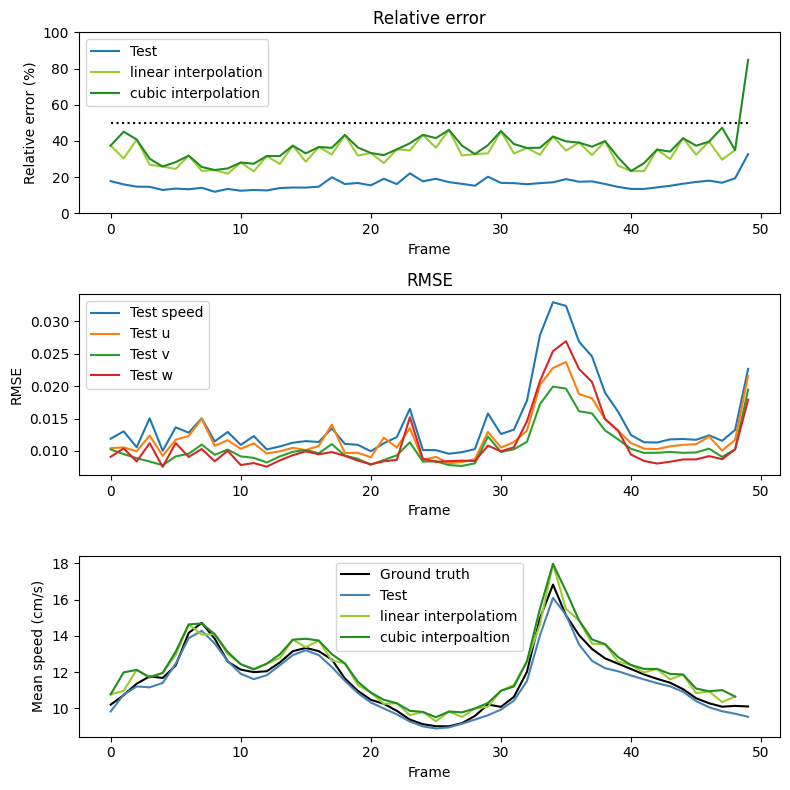

In [13]:
plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
#plot_relative_error([gt_filepath],[res_filepath], [set_name])

#plt.legend(lst_names)
plt.title("Relative error")
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = f'{set_name} speed')
plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = f'{set_name} u')
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = f'{set_name} v')
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = f'{set_name} w')
plt.ylabel('RMSE')
plt.xlabel('Frame')
plt.title('RMSE')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
plt.plot(pred['mean_speed'],'b', label= set_name, color = 'steelblue')
plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolatiom', color = 'yellowgreen')
plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/RE_RMSE_MEAN_SPEED.svg',bbox_inches='tight')
plt.show()
#lst_hgt_paths, lst_hpred_paths,lst_names, save_as = 'Relative_error_comparison.png'

max/min before tanh 52297.324 0.0
max/min after tanh 1.0 0.0
max/min before tanh 52297.324 0.0
max/min after tanh 1.0 0.0


/tmp/ipykernel_993998/1879011466.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2 , 1)


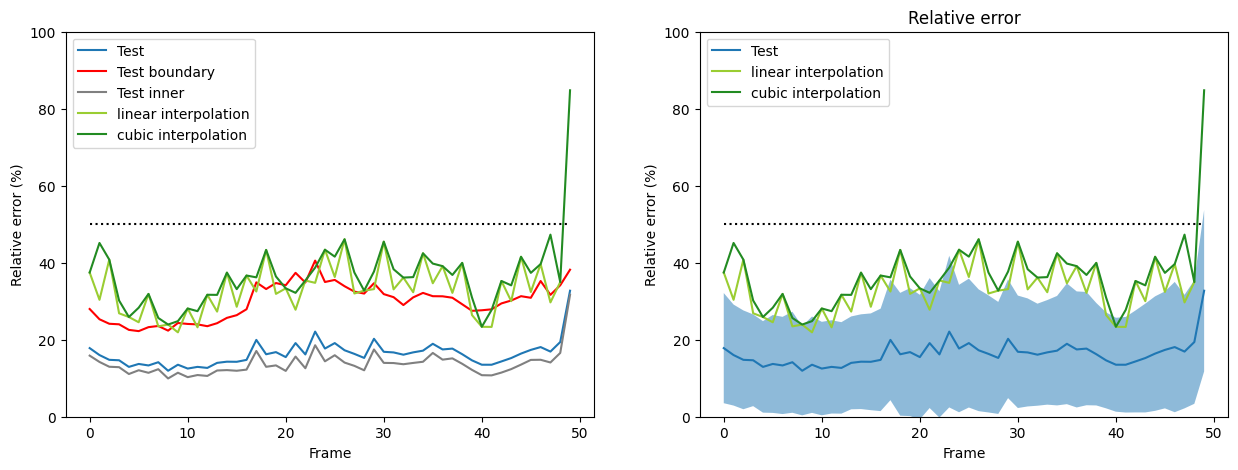

In [14]:
plt.figure(figsize=(15, 5))

rel_error_inner = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], core_mask)
rel_error_bounds = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], bounds)
# plt.subplot(3, 1, 1)

#plt.legend(lst_names)
plt.title("Relative error")
plt.subplot(1,2 , 1)
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_bounds, label = f'{set_name} boundary', color = 'red')
plt.plot(rel_error_inner, label = f'{set_name} inner', color ='gray')
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(1, 2, 2)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()
points_in_mask = np.where(temporal_mask !=0)

reshaped_error = np.tanh(error_pointwise[:, points_in_mask[1], points_in_mask[2], points_in_mask[3]].reshape(frames, -1))
max_error = np.max(reshaped_error, axis=1)*100

sd_error = np.std(reshaped_error, axis = 1)*100
error = np.random.normal(0, sd_error, size=len(rel_error))
plt.fill_between(range(len(rel_error)), rel_error-sd_error, rel_error+sd_error, alpha = 0.5)

### Quiver plot testing

In [15]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

set_to_zero = 0.9



@widgets.interact(frame=(0, gt["u"].shape[0]-1))
def f_quiver(frame=10 ):
    #frame = 15
    u_quiver = gt['u'][frame].copy() #- pred['u'][frame]
    v_quiver = gt['v'][frame].copy() #- pred['v'][frame]
    w_quiver = gt['w'][frame].copy() #- pred['w'][frame]

    x_idx, y_idx, z_idx = random_indices3D(temporal_mask[frame], int(np.count_nonzero(temporal_mask[frame])*set_to_zero))
    x_len, y_len, z_len = gt['u'].shape[1::]

    # ev = np.array([1, 0, 0])
    #angles = np.arccos(np.dot(ev, [u, v, w]) / (np.linalg.norm(ev) * np.linalg.norm(v2)))
    # angles = np.multiply
    # Make the grid
    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    u_quiver[x_idx, y_idx, z_idx] = 0
    v_quiver[x_idx, y_idx, z_idx] = 0
    w_quiver[x_idx, y_idx, z_idx] = 0

    cropx = cropy = cropz = 25
    startx = x_len//2-(cropx//2)
    starty = y_len//2-(cropy//2)    
    startz = z_len//2-(cropz//2)
    u_quiver = u_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    v_quiver = v_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    w_quiver = w_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 

    x =x[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    y =y[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    z =z[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz]

    u_new = u_quiver[np.where(u_quiver != 0)]
    v_new = v_quiver[np.where(u_quiver != 0)]
    w_new = w_quiver[np.where(u_quiver != 0)]

    x_new = x[np.where(u_quiver!=0)] 
    y_new = y[np.where(u_quiver!=0)] 
    z_new = z[np.where(u_quiver!=0)]


    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.jet(c)


    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.zlabel('z')
    plt.show()

interactive(children=(IntSlider(value=10, description='frame', max=49), Output()), _dom_classes=('widget-inter…

In [16]:
def create_temporal_comparison_gif_plt(idx, lr, hr, pred, vel):
    N = 4
    v_lr = lr[vel]
    v_hr = hr[vel]
    v_pred = pred[vel]
    v_error_abs= error_absolut[f'{vel}']
    v_NN = temporal_NN_interpolation(v_lr,v_hr.shape )

    err_max = np.quantile(v_error_abs[np.where(temporal_mask !=0)].flatten(), 0.999)

    fig = plt.figure(frameon=False)
    plt.subplot(1, N, 1)
    im1 = plt.imshow(v_NN[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 2)
    im2 = plt.imshow(v_hr[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 3)
    im3 = plt.imshow(v_pred[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')

    plt.subplot(1, N, 4)
    im4 = plt.imshow(v_error_abs[0, idx, :, :],vmin=0, vmax=err_max)
    plt.axis('off')
    plt.colorbar(im4,fraction=0.046, pad=0.04)
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()


    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        im2.set_data(np.random.random((5,5)))
        im3.set_data(np.random.random((5,5)))
        im4.set_data(np.random.random((5,5)))
        return [im1, im2, im3]

    # animation function.  This is called sequentially
    def animate(i):
        
        im1.set_array(v_NN[i, idx, :, :])
        im2.set_array(v_hr[i, idx, :, :])
        im3.set_array(v_pred[i, idx, :, :])
        im4.set_array(v_error_abs[i, idx, :, :])
        
        return [im1, im2, im3]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    print("Gif is saved under:" f'{eval_dir}/Animate_{vel}_{set_name}_M{data_model}.gif')
    anim.save(f'{eval_dir}/Animate_{vel}_{set_name}_M{data_model}.gif', fps=300)

def create_temporal_comparison_gif_single(idx, data, vel, title):

    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    # im1 = plt.imshow(data[0, idx, :, :],interpolation='none', vmin=min_v[vel], vmax=max_v[vel])
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, idx, :, :])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/Animate_{title}_{vel}.gif', fps=300)

    #generate_gif_volume(combined_image[:,idx, :, : ], axis = 0, save_as = save_as)

# create_temporal_comparison_gif_plt(22, lr, gt, pred, "u")
# create_temporal_comparison_gif_plt(22, lr, gt, pred, "v")
# create_temporal_comparison_gif_plt(22, lr, gt, pred, "w")
#create_temporal_comparison_gif_plt(22, lr, gt, pred, "speed")
velo = 'u'
# create_temporal_comparison_gif_single(22, temporal_NN_interpolation(lr[velo],gt[velo].shape), velo, "LR")
# create_temporal_comparison_gif_single(22, gt[velo],velo , "HR")
# create_temporal_comparison_gif_single(22, pred[velo],velo, "4DFlowNet")
# create_temporal_comparison_gif_single(22, interpolate_linear[velo], velo, "linear interpoaltion")
# First set up the figure, the axis, and the plot element we want to animate


### Plot correlation lines

In [17]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1))
def f_regression(frame=10 ):
    plt.figure(figsize=(15, 5))
    plot_correlation(gt, pred,bounds, frame_idx=frame, save_as= f'{eval_dir}/Correlation_')
    plt.show()

interactive(children=(IntSlider(value=10, description='frame', max=49), Output()), _dom_classes=('widget-inter…

### Plot k, $R^2$ values in time

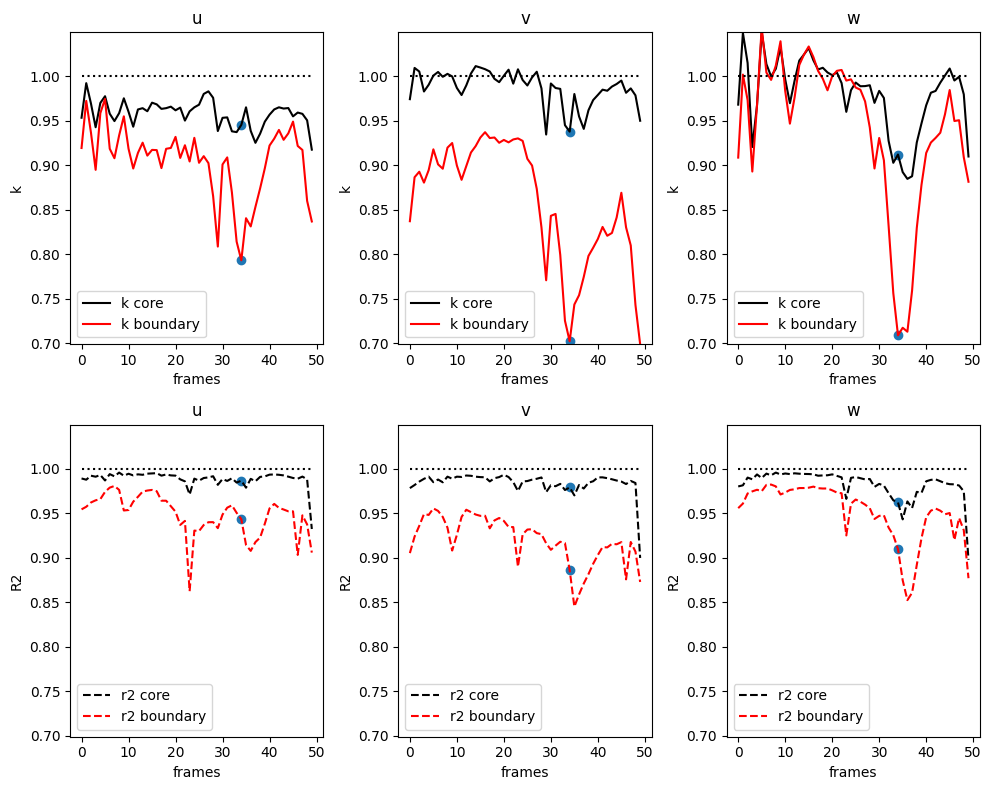

In [18]:
peak_flow_frame = np.unravel_index(np.argmax(gt['speed']), shape = gt['speed'].shape)[0]
frames = len(rel_error)
k = np.zeros(3*frames)
r2 = np.zeros(3*frames)
k_bounds = np.zeros(3*frames)
r2_bounds = np.zeros(3*frames)
bounds_mask = bounds.copy()
inner_mask = temporal_mask - bounds_mask
for i, vel in enumerate(vel_colnames):
    for t in range(frames):
        k[t+i*frames], r2[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], core_mask[t])
        k_bounds[t+i*frames], r2_bounds[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], bounds[t])

min_val = np.minimum(np.min(k_bounds), np.min(r2_bounds))
max_val = np.maximum(np.max(k), np.max(r2))
for i, vel in enumerate(vel_colnames):
    plt.subplot(2, 3, i+1)
    plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
    plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] , label = 'k boundary', color = 'red')
    plt.plot(np.ones(len(rel_error)), 'k:')
    plt.ylim([min_val, max_val])
    plt.title(vel)
    plt.xlabel('frames')
    plt.ylabel('k')
    plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] )
    plt.legend()
for i, vel in enumerate(vel_colnames):
    plt.subplot(2, 3, i+4)
    plt.plot(range(frames), r2[i*frames:i*frames+frames] ,'--', label = 'r2 core', color = 'black')
    plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = 'r2 boundary', color = 'red')
    plt.plot(np.ones(len(rel_error)), 'k:')
    plt.ylim([min_val, max_val])
    plt.title(vel)
    plt.xlabel('frames')
    plt.ylabel('R2')
    plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] )
    plt.legend()
    
plt.tight_layout()

### Plot line development in time

In [19]:

#def show_temporal_development_line(gt, lr, pred, mask, axis, indices, save_as = "Temporal_development.png"):
@widgets.interact(x=(0, gt["u"].shape[1]-1), y = (0, gt["u"].shape[2]-1), vel=vel_colnames_fluid, axis=(1, 3))
def f_temporal_development_lines(x = 30,y =40, vel = "u", axis =1):

        indices = (x, y)
        def get_line(data):
            #returns line in 4D data over all time steps
            x,y = indices
            if axis == 1:
                return data[:, :, x, y]
            elif axis == 2:
                return data[:, x, :, y]
            elif axis == 3:
                return data[:, x,  y, :]
            else:
                print("Invalid axis: Please choose axis 1, 2, 3")

        prediction = get_line(pred[vel]).transpose()
        ground_truth = get_line(gt[vel]).transpose()
        low_resolution= get_line(interpolate_NN[vel]).transpose()

        min_v = np.min([np.min(prediction), np.min(ground_truth), np.min(low_resolution)])
        max_v = np.max([np.max(prediction), np.max(ground_truth), np.max(low_resolution)])


        plt.subplot(1, 3, 1)
        plt.imshow(low_resolution, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("LR")
        plt.xlabel('t')
        plt.yticks([])

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("GT")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 3, 3)
        plt.imshow(prediction, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("SR")
        plt.xticks([])
        plt.yticks([])

interactive(children=(IntSlider(value=30, description='x', max=61), IntSlider(value=40, description='y', max=5…

### Plot peak flow development

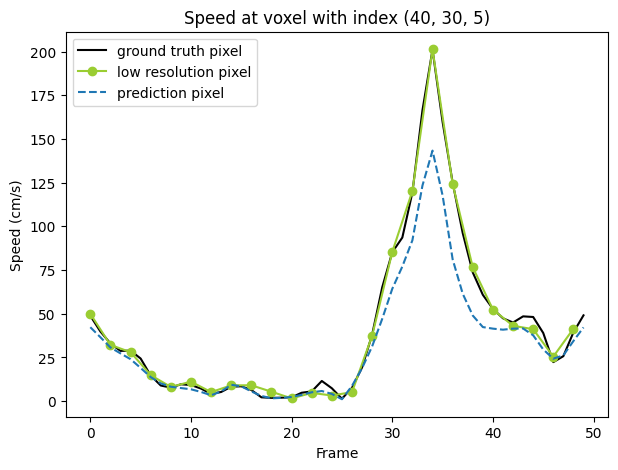

In [20]:
#Params for plot
patch_size = 1
show_avg = False
show_pixel = True

def show_peak_flow_pixel(lr_data, hr_data,pred_data,  patch_size, show_avg, show_pixel):
    plt.figure(figsize=(7, 5))
    idx_max = np.unravel_index(np.argmax(hr_data['speed']), shape = hr_data['speed'].shape)
    x = np.arange(hr_data['speed'].shape[0])
    if show_pixel:
        plt.plot(x, hr_data['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,  label = 'ground truth pixel', color = 'black')
        plt.plot(x[::2], lr['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'-o' ,label = 'low resolution pixel', color= 'yellowgreen')
        plt.plot(x, pred['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'--', label = 'prediction pixel')

    if show_avg:
        plt.plot(x,         np.average(hr_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,  label = 'ground truth avg', color = 'black')
        plt.plot(x[::2],    np.average(lr_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'-o' ,label = 'low resolution avg')
        plt.plot(x,         np.average(pred_data['speed'][:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'--', label = 'prediction avg')
    if show_avg:
        plt.title(f"Speed at voxel {idx_max[1::]} with average of number of voxels: {(2*patch_size+1)**3}")
    else:
        plt.title(f"Speed at voxel with index {idx_max[1::]}")
    plt.ylabel('Speed (cm/s)')
    plt.ylabel('Speed (cm/s)')
    plt.xlabel('Frame')
    plt.legend()
    plt.savefig(f'{eval_dir}/Peak_flow_frame.svg',bbox_inches='tight')
    plt.show()

show_peak_flow_pixel(lr, gt, pred, patch_size, show_avg, show_pixel)

## Compare multiple models in the same set

### Comparison depth resnet

In [21]:
model_names = ['20230301-1641' ] ## resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name for _ in range(len(model_names))]
labels = [f'Static_{set_names[0]}', f'C{model_names[0][-4:]}_{set_names[0]}']
colors = ['darkorange', 'brown', 'orchid', 'darkviolet']
name_comparison = 'Static_dynamic_mask'
name_base_net = 'Dynamic mask'
# comparison_multiple_models(model_names, set_names, labels, colors,name_base_net, name_comparison)
